# Reconocimiento de Imágenes en CIFAR10

Para experimentar con el reconocimiento de imágenes y la clasificación se estudia el dataset *CIFAR10*, el cual contiene 60.000 imagenes de 32 $\times$ 32 (pixeles), donde cada imagen pertenece a una de las diez clases, clasificación excluyente (gato, perro, rana, caballo, pájaro, ciervo, avión, automóvil, camión y barco). Los datos vienen estructurado en un formato RGB, donde cada imagen (fila del dataset) corresponde a 3072 características, dividido en los 3 canales de RGB (1024 cada uno) correspondiente a cada imagen.  
Los datos vienen separados en datos de entrenamiento y de pruebas, para un estudio eficiente con las distintas arquitecturas que ofrecen las *redes neuronales*, además de analizar distintas representaciones de imágenes.

In [1]:
import os    
os.environ['THEANO_FLAGS'] = "device=gpu,floatX=float32,cuda.root=/usr/local/cuda-7.5/" 

import theano
import keras
print theano.config

import matplotlib.pyplot as plt
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler

from scipy.misc import imread
import cPickle as pickle
import numpy as np
import math

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce 940M (CNMeM is disabled, cuDNN 5110)
Using Theano backend.


floatX (('float64', 'float32', 'float16')) 
    Doc:  Default floating-point precision for python casts.

Note: float16 support is experimental, use at your own risk.
    Value:  float32

warn_float64 (('ignore', 'warn', 'raise', 'pdb')) 
    Doc:  Do an action when a tensor variable with float64 dtype is created. They can't be run on the GPU with the current(old) gpu back-end and are slow with gamer GPUs.
    Value:  ignore

cast_policy (('custom', 'numpy+floatX')) 
    Doc:  Rules for implicit type casting
    Value:  custom

int_division (('int', 'raise', 'floatX')) 
    Doc:  What to do when one computes x / y, where both x and y are of integer types
    Value:  int

device (cpu, gpu*, opencl*, cuda*) 
    Doc:  Default device for computations. If cuda* or opencl*, change thedefault to try to move computation to the GPU. Do not use upper caseletters, only lower case even if NVIDIA uses capital letters.
    Value:  gpu

init_gpu_device (, gpu*, opencl*, cuda*) 
    Doc:  Initialize 

[[ 59  43  50 ..., 140  84  72]
 [154 126 105 ..., 139 142 144]
 [255 253 253 ...,  83  83  84]
 ..., 
 [ 71  60  74 ...,  68  69  68]
 [250 254 211 ..., 215 255 254]
 [ 62  61  60 ..., 130 130 131]]
min value 0
max value 255


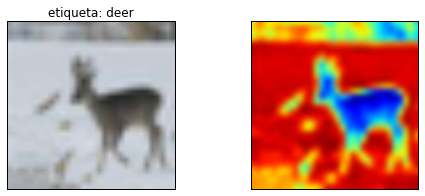

In [2]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

dict1 = unpickle("data/data_batch_1")
X = dict1["data"]
print X
Y = dict1['labels']
print "min value" ,min(X[0])
print "max value" ,max(X[0])

label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

def ver_imagen(X,Y,n):
    aux = X[n].reshape(3,1024).copy()
    canal_r = aux[0].reshape(32,32)
    canal_g = aux[1].reshape(32,32)
    canal_b = aux[2].reshape(32,32)
    
    f,ax = plt.subplots(1,2,figsize=(8,3))
    ax[0].set_title("etiqueta: "+label_names[Y[n]])
    
    imagen = X[n].reshape(3,32,32)
    imagen = imagen.transpose([1, 2, 0])

    ax[0].imshow(imagen)
    ax[0].set_yticks([])
    ax[0].set_xticks([])

    ax[1].imshow(canal_r, interpolation="bicubic")
    ax[1].imshow(canal_g, interpolation="bicubic")
    ax[1].imshow(canal_b, interpolation="bicubic")
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    plt.show()
    
ver_imagen(X,Y,20)

### Cargar Dataset

In [2]:
def load_CIFAR_one(filename):
    with open(filename, "rb") as f:
        datadict = pickle.load(f)
        X = datadict["data"]
        Y = datadict["labels"]
        return X, np.array(Y)

def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(PATH, "data_batch_%d" % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    
    Xte, Yte = load_CIFAR_one(os.path.join(PATH, "test_batch"))
    
    #adding Xval
    index = np.arange(np.shape(Xtr)[0]) #filas 
    np.random.shuffle(index) #permutan las filas
    X = Xtr[index, :] #matriz permutada
    Y = Ytr[index]
    #l =  np.random.randint(1000,5000) #entrego 4259
    l = 4259
    Xval,Xtr = np.split(X,[l])
    Yval,Ytr = np.split(Y,[l])
    
    return Xtr, Ytr, Xte, Yte,Xval,Yval

x_train,y_train, x_test,y_test, x_val,y_val = load_CIFAR10('data/')

#ESCALAR

x_train = x_train/255.0
x_test = x_test/255.0
x_val = x_val/255.0


print 'Training set shape: ',x_train.shape
print 'Validation set shape: ',x_val.shape
print 'Test set shape: ',x_test.shape 

Training set shape:  (45741, 3072)
Validation set shape:  (4259, 3072)
Test set shape:  (10000, 3072)


En la celda anterior se carga el dataset de CIFAR10, el cual está dividido en *batchs*. Se crean las matrices $X_{train}$, $Y_{train}$, $X_{test}$, $Y_{test}$ y $X_{val}$, $Y_{val}$. El conjunto de validación es creado a partir del *training set* y este no supera los 5000 datos. Las filas de estas matrices representan a cada imagen del dataset, siendo los valores de la fila valores enteros de 0 a 255, que representan los valores de los colores que vienen por los canales *R*,*G* y *B*.  
Se puede observar que la matriz $X_{train}$ posee 45741 filas, es decir, 45741 imagenes de entrenamiento. Por otro lado $X_{val}$ posee 4259 imágenes de validación y $X_{test}$ 10000 imágenes de prueba. Las 10 etiquetas están codificadas en números enteros del 0 al 9.  

En esta celda se escala la representación matricial de píxeles de las imágenes, para poder trabajarlas de forma apropiada, normalizando por la intensidad máxima 255, dejando cada atributo en un intervalo entre 0 y 1.

In [4]:
def plot_function(hist):
    loss_values1 = hist['loss']
    val_loss_values1 = hist['val_loss']
    epochs1 = range(1, len(loss_values1) + 1)
    f, axarr = plt.subplots(1, 2,figsize=(16,5))
    
    axarr[0].plot(epochs1, loss_values1, 'bo-')
    axarr[0].plot(epochs1, val_loss_values1, 'go-')
    axarr[0].set_title('Loss de CNN')
    axarr[0].set_ylim(0,2)
    axarr[0].set_xlabel('Epochs')
    axarr[0].set_ylabel('Loss')

    acc = hist['acc']
    val_acc = hist['val_acc']
    axarr[1].plot(epochs1,  np.subtract(1,acc), 'bo-', label = "Training set")
    axarr[1].plot(epochs1, np.subtract(1,val_acc), 'go-', label = "Test set")
    axarr[1].set_title('Error de CNN')
    axarr[1].set_ylim(0,.8)
    axarr[1].set_xlabel('Epochs')
    axarr[1].set_ylabel('Error')
    axarr[1].legend(loc="upper right", fancybox= True)
    plt.show()  

## A) Ajuste/Preprocesamiento

In [3]:
x_train = x_train.reshape((x_train.shape[0],32,32,3))
#x_train = x_train.transpose([0, 1, 2, 3]) #only if 'tf' dim-ordering is to be used
x_test= x_test.reshape((x_test.shape[0],32,32,3))
#x_test= x_test.transpose([0, 3, 1,2])#remove if 'th' dim-ordering is to be used
y_train = keras.utils.np_utils.to_categorical(y_train, 10)
y_test = keras.utils.np_utils.to_categorical(y_test, 10)

## B) Definir una CNN ( C x P )

In [17]:
model = Sequential()
model.add(Conv2D( 64, (3, 3) , padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D( 64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_6 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
__________

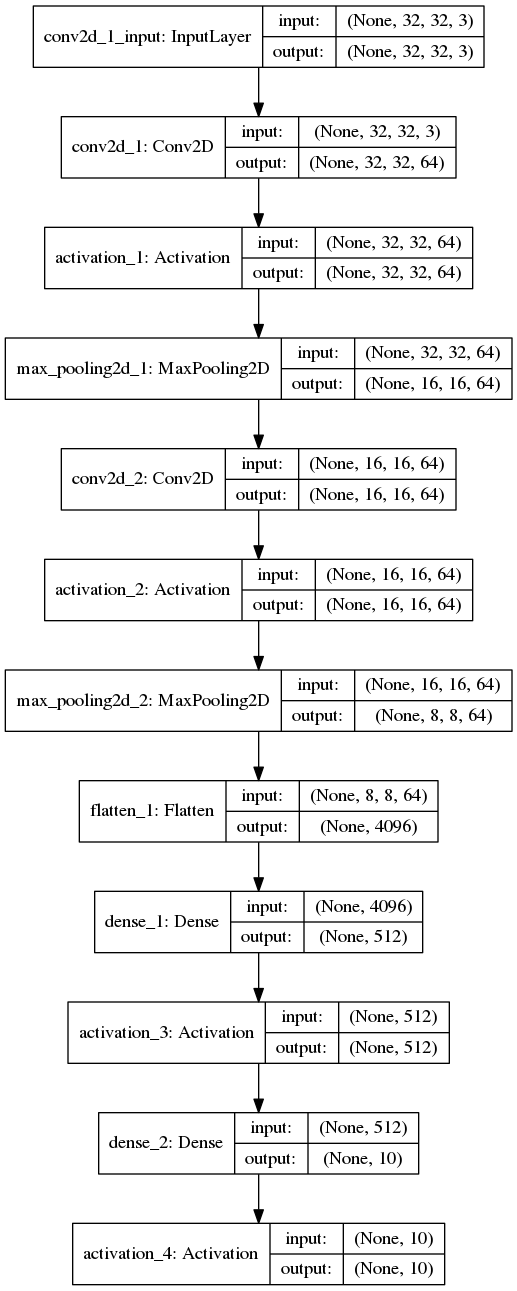

In [6]:
plot_model(model, to_file='aux.png', show_shapes=True)
Image(filename='aux.png') 

## C) Entrenar la red (SGD)

In [6]:
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile( optimizer=opt, loss='categorical_crossentropy',metrics=['acc'])
hist2 = model.fit(x_train, y_train,batch_size=100,epochs=25,
validation_data=(x_test, y_test),shuffle=True,callbacks=[lrate],verbose=1)

Train on 45741 samples, validate on 10000 samples
Epoch 1/25
45741/45741 [==============================] - 63s - loss: 2.1363 - acc: 0.2305 - val_loss: 1.9451 - val_acc: 0.3056
Epoch 2/25
45741/45741 [==============================] - 63s - loss: 1.8742 - acc: 0.3346 - val_loss: 1.7576 - val_acc: 0.3834
Epoch 3/25
45741/45741 [==============================] - 62s - loss: 1.7126 - acc: 0.3984 - val_loss: 1.6664 - val_acc: 0.4137
Epoch 4/25
45741/45741 [==============================] - 63s - loss: 1.6016 - acc: 0.4321 - val_loss: 1.5723 - val_acc: 0.4333
Epoch 5/25
45741/45741 [==============================] - 64s - loss: 1.5268 - acc: 0.4611 - val_loss: 1.5067 - val_acc: 0.4709
Epoch 6/25
45741/45741 [==============================] - 64s - loss: 1.4978 - acc: 0.4723 - val_loss: 1.4755 - val_acc: 0.4852
Epoch 7/25
45741/45741 [==============================] - 62s - loss: 1.4701 - acc: 0.4836 - val_loss: 1.4762 - val_acc: 0.4794
Epoch 8/25
45741/45741 [==============================

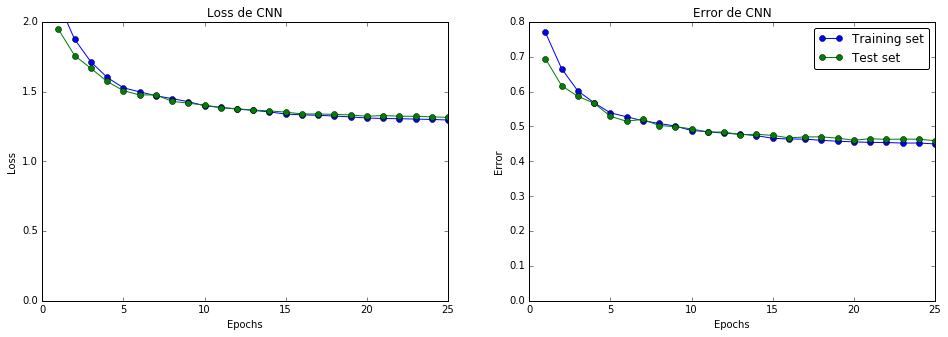

In [82]:
history_dict = hist2.history
plot_function(history_dict)

In [8]:
score = model.evaluate(x_test, y_test)
print "\nTEST CROSS ENTROPY LOSS = ", score[0]
print "\nTEST ACCURACY = ", score[1]

 9888/10000 [============================>.] - ETA: 0s
TEST CROSS ENTROPY LOSS =  1.31503149624

TEST ACCURACY =  0.5408


## D) Entrenar la red (RMSProp)

In [18]:
opt = rmsprop(lr=0.001, decay=1e-3)
model.compile( optimizer=opt, loss='categorical_crossentropy' ,metrics=['acc'])
hist3 = model.fit(x_train, y_train,batch_size=100,epochs=25,
validation_data=(x_test, y_test),shuffle=True)

Train on 45741 samples, validate on 10000 samples
Epoch 1/25
45741/45741 [==============================] - 61s - loss: 1.6440 - acc: 0.4237 - val_loss: 1.4593 - val_acc: 0.4978
Epoch 2/25
45741/45741 [==============================] - 56s - loss: 1.2271 - acc: 0.5713 - val_loss: 1.1730 - val_acc: 0.5839
Epoch 3/25
45741/45741 [==============================] - 55s - loss: 1.0604 - acc: 0.6296 - val_loss: 1.1520 - val_acc: 0.6026
Epoch 4/25
45741/45741 [==============================] - 56s - loss: 0.9417 - acc: 0.6714 - val_loss: 1.1572 - val_acc: 0.6011
Epoch 5/25
45741/45741 [==============================] - 56s - loss: 0.8571 - acc: 0.7033 - val_loss: 1.0388 - val_acc: 0.6383
Epoch 6/25
45741/45741 [==============================] - 56s - loss: 0.7820 - acc: 0.7321 - val_loss: 1.0256 - val_acc: 0.6445
Epoch 7/25
45741/45741 [==============================] - 56s - loss: 0.7190 - acc: 0.7546 - val_loss: 1.0145 - val_acc: 0.6543
Epoch 8/25
45741/45741 [==============================

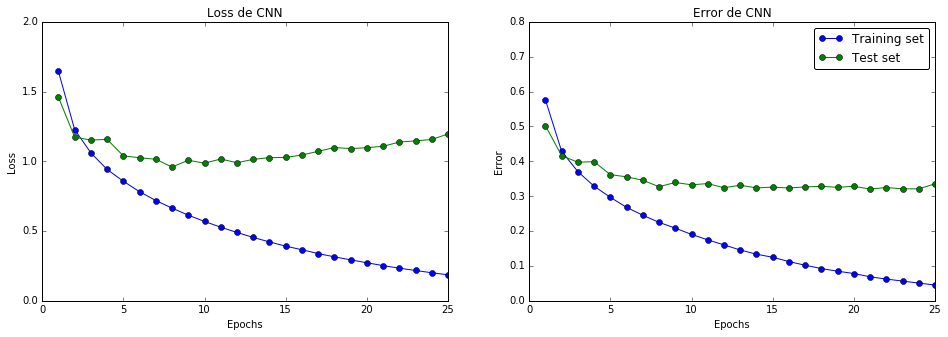

In [19]:
history_dict = hist3.history
plot_function(history_dict)

In [9]:
score = model.evaluate(x_test, y_test)
print "\nTEST CROSS ENTROPY LOSS = ", score[0]
print "\nTEST ACCURACY = ", score[1]

 9824/10000 [============================>.] - ETA: 0s
TEST CROSS ENTROPY LOSS =  1.14163003025

TEST ACCURACY =  0.6824


## E) Variar red ( C x C x P )

In [10]:
model = Sequential()
#primera C C P
model.add(Conv2D( 64, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
model.add(Conv2D( 64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#segunda C C P
model.add(Conv2D( 128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D( 128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Feed Forward
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 128)         0         
__________

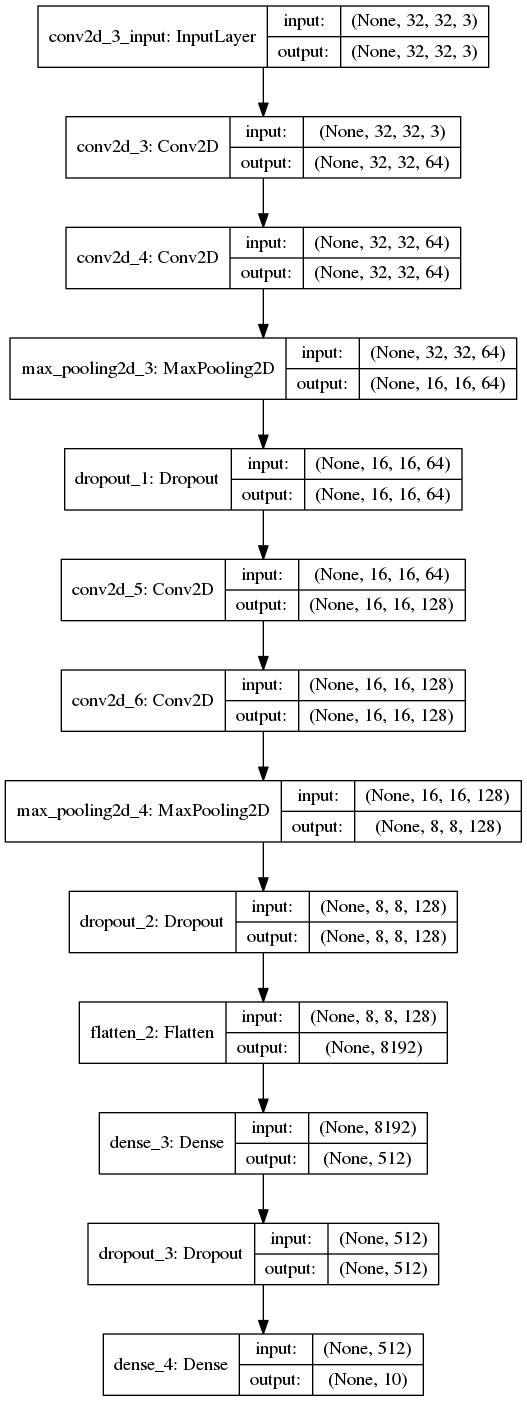

In [11]:
plot_model(model, to_file='aux.png', show_shapes=True)
Image(filename='aux.png')

In [12]:
opt = rmsprop(lr=0.001, decay=1e-3)
model.compile( optimizer=opt, loss='categorical_crossentropy' ,metrics=['acc'])
hist4 = model.fit(x_train, y_train,batch_size=100,epochs=25,
                  validation_data=(x_test, y_test),shuffle=True,verbose=1)

Train on 45741 samples, validate on 10000 samples
Epoch 1/25
45741/45741 [==============================] - 160s - loss: 1.7226 - acc: 0.3845 - val_loss: 1.3977 - val_acc: 0.5037
Epoch 2/25
45741/45741 [==============================] - 160s - loss: 1.2727 - acc: 0.5525 - val_loss: 1.1911 - val_acc: 0.5764
Epoch 3/25
45741/45741 [==============================] - 160s - loss: 1.0832 - acc: 0.6222 - val_loss: 1.0248 - val_acc: 0.6403
Epoch 4/25
45741/45741 [==============================] - 160s - loss: 0.9577 - acc: 0.6655 - val_loss: 0.9600 - val_acc: 0.6665
Epoch 5/25
45741/45741 [==============================] - 160s - loss: 0.8648 - acc: 0.6996 - val_loss: 0.9411 - val_acc: 0.6768
Epoch 6/25
45741/45741 [==============================] - 160s - loss: 0.7922 - acc: 0.7230 - val_loss: 0.9336 - val_acc: 0.6759
Epoch 7/25
45741/45741 [==============================] - 167s - loss: 0.7297 - acc: 0.7467 - val_loss: 0.9277 - val_acc: 0.6935
Epoch 8/25
45741/45741 [=======================

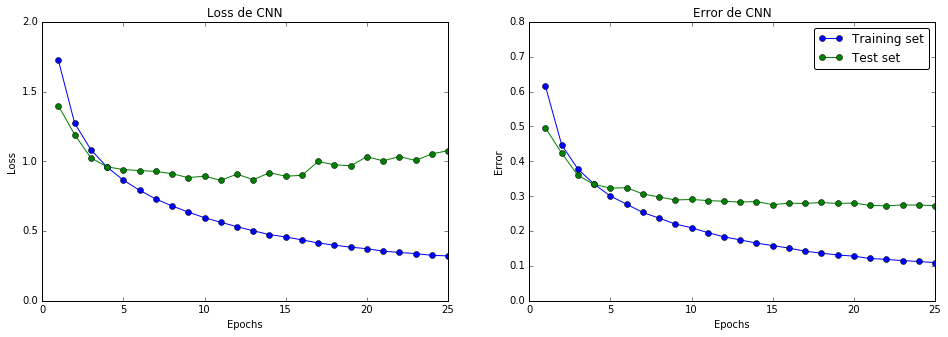

In [13]:
history_dict = hist4.history
plot_function(history_dict)

In [14]:
score = model.evaluate(x_test, y_test)
print "\nTEST CROSS ENTROPY LOSS = ", score[0]
print "\nTEST ACCURACY = ", score[1]

 9984/10000 [============================>.] - ETA: 0s
TEST CROSS ENTROPY LOSS =  1.0763462009

TEST ACCURACY =  0.7273


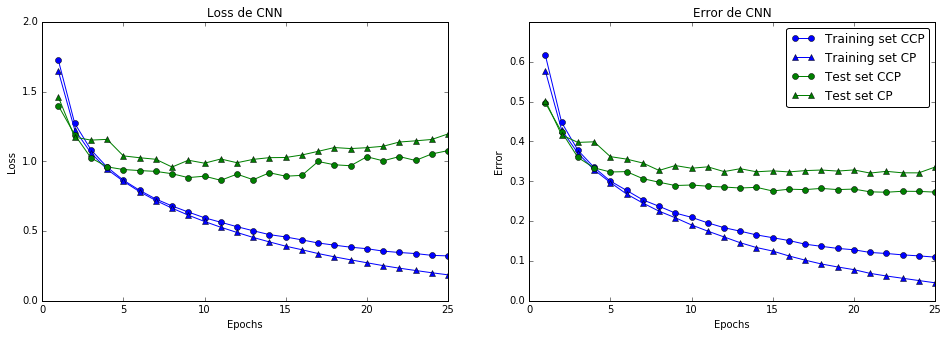

In [20]:
history_dict1 = hist4.history #modelos a comparar

history_dict2 = hist3.history #modelo a comparar

f, axarr = plt.subplots(1, 2,figsize=(16,5))

loss_values1 = history_dict1['loss']
val_loss_values1 = history_dict1['val_loss']
loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']
epochs1 = range(1, len(loss_values1) + 1)

axarr[0].plot(epochs1, loss_values1, 'bo-', label = "Training set CCP")
axarr[0].plot(epochs1, loss_values2, 'b^-', label = "Training set CP")
axarr[0].plot(epochs1, val_loss_values1, 'go-', label = "Test set CCP")
axarr[0].plot(epochs1, val_loss_values2, 'g^-', label = "Test set CP")
axarr[0].set_title('Loss de CNN')
axarr[0].set_ylim(0,2)
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Loss')

acc1 = history_dict1['acc']
val_acc1 = history_dict1['val_acc']
acc2 = history_dict2['acc']
val_acc2 = history_dict2['val_acc']

axarr[1].plot(epochs1, np.subtract(1,acc1), 'bo-', label = "Training set CCP")
axarr[1].plot(epochs1, np.subtract(1,acc2), 'b^-', label = "Training set CP")
axarr[1].plot(epochs1, np.subtract(1,val_acc1), 'go-', label = "Test set CCP")
axarr[1].plot(epochs1, np.subtract(1,val_acc2), 'g^-', label = "Test set CP")
axarr[1].set_title('Error de CNN')
axarr[1].set_ylim(0,0.7)
axarr[1].set_xlabel('Epochs')
axarr[1].set_ylabel('Error')
axarr[1].legend(loc="upper right", fancybox= True)

plt.show()

### Menos filtros en la capa siguiente

In [21]:
model = Sequential()
model.add(Conv2D( 128, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
model.add(Conv2D( 128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D( 64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D( 64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Feed Forward
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        73792     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [23]:
opt = rmsprop(lr=0.001, decay=1e-3)
model.compile( optimizer=opt, loss='categorical_crossentropy' ,metrics=['acc'])
hist5 = model.fit(x_train, y_train,batch_size=100,epochs=25,
validation_data=(x_test, y_test),shuffle=True,verbose=1)

Train on 45741 samples, validate on 10000 samples
Epoch 1/25
45741/45741 [==============================] - 282s - loss: 1.7423 - acc: 0.3755 - val_loss: 1.3898 - val_acc: 0.5004
Epoch 2/25
45741/45741 [==============================] - 285s - loss: 1.3039 - acc: 0.5386 - val_loss: 1.2387 - val_acc: 0.5561
Epoch 3/25
45741/45741 [==============================] - 283s - loss: 1.1280 - acc: 0.6014 - val_loss: 1.1390 - val_acc: 0.5909
Epoch 4/25
45741/45741 [==============================] - 283s - loss: 1.0158 - acc: 0.6440 - val_loss: 1.0425 - val_acc: 0.6343
Epoch 5/25
45741/45741 [==============================] - 283s - loss: 0.9367 - acc: 0.6730 - val_loss: 0.9578 - val_acc: 0.6610
Epoch 6/25
45741/45741 [==============================] - 283s - loss: 0.8666 - acc: 0.6969 - val_loss: 0.9578 - val_acc: 0.6625
Epoch 7/25
45741/45741 [==============================] - 283s - loss: 0.8111 - acc: 0.7169 - val_loss: 0.9126 - val_acc: 0.6745
Epoch 8/25
45741/45741 [=======================

In [24]:
score = model.evaluate(x_test, y_test)
print "\nTEST CROSS ENTROPY LOSS = ", score[0]
print "\nTEST ACCURACY = ", score[1]

10000/10000 [==============================] - 11s    

TEST CROSS ENTROPY LOSS =  0.91770440731

TEST ACCURACY =  0.7181


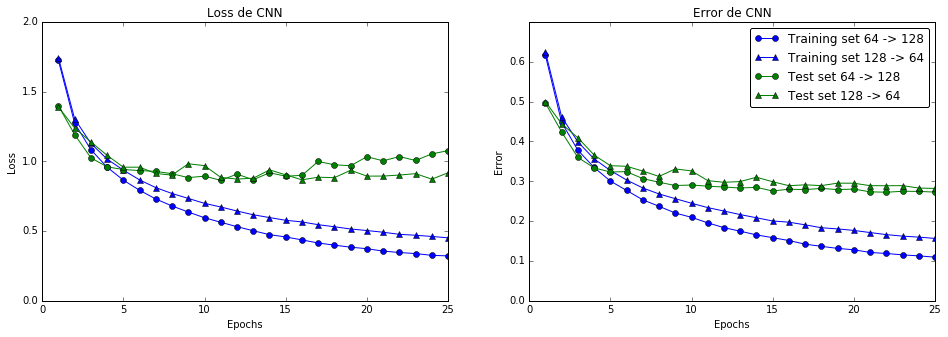

In [25]:
history_dict1 = hist4.history
history_dict2 = hist5.history

f, axarr = plt.subplots(1, 2,figsize=(16,5))

loss_values1 = history_dict1['loss']
val_loss_values1 = history_dict1['val_loss']
loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']
epochs1 = range(1, len(loss_values1) + 1)

axarr[0].plot(epochs1, loss_values1, 'bo-')
axarr[0].plot(epochs1, loss_values2, 'b^-')
axarr[0].plot(epochs1, val_loss_values1, 'go-')
axarr[0].plot(epochs1, val_loss_values2, 'g^-')
axarr[0].set_title('Loss de CNN')
axarr[0].set_ylim(0,2)
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Loss')

acc1 = history_dict1['acc']
val_acc1 = history_dict1['val_acc']
acc2 = history_dict2['acc']
val_acc2 = history_dict2['val_acc']

axarr[1].plot(epochs1, np.subtract(1,acc1), 'bo-', label = "Training set 64 -> 128")
axarr[1].plot(epochs1, np.subtract(1,acc2), 'b^-', label = "Training set 128 -> 64")
axarr[1].plot(epochs1, np.subtract(1,val_acc1), 'go-', label = "Test set 64 -> 128")
axarr[1].plot(epochs1, np.subtract(1,val_acc2), 'g^-', label = "Test set 128 -> 64")
axarr[1].set_title('Error de CNN')
axarr[1].set_ylim(0,0.7)
axarr[1].set_xlabel('Epochs')
axarr[1].set_ylabel('Error')
axarr[1].legend(loc="upper right", fancybox= True)
plt.show()

### Cambio del tamaño del filtro

In [4]:
model = Sequential()
model.add(Conv2D( 64, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
model.add(Conv2D( 64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D( 128, (5, 5), padding='same', activation='relu'))
model.add(Conv2D( 128, (5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Feed Forward
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       409728    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
__________

In [ ]:
opt = rmsprop(lr=0.001, decay=1e-3)
model.compile( optimizer=opt, loss='categorical_crossentropy' ,metrics=['acc'])
hist6 = model.fit(x_train, y_train,batch_size=100,epochs=25,
                  validation_data=(x_test, y_test),shuffle=True,verbose=1)

In [ ]:
history_dict = hist6.history
plot_function(history_dict)
score = model.evaluate(x_test, y_test)
print "\nTEST CROSS ENTROPY LOSS = ", score[0]
print "\nTEST ACCURACY = ", score[1]

In [ ]:
history_dict1 = hist4.history
history_dict2 = hist6.history

f, axarr = plt.subplots(1, 2,figsize=(16,5))

loss_values1 = history_dict1['loss']
val_loss_values1 = history_dict1['val_loss']
loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']
epochs1 = range(1, len(loss_values1) + 1)

axarr[0].plot(epochs1, loss_values1, 'bo-')
axarr[0].plot(epochs1, loss_values2, 'b^-')
axarr[0].plot(epochs1, val_loss_values1, 'go-')
axarr[0].plot(epochs1, val_loss_values2, 'g^-')
axarr[0].set_title('Loss de CNN')
axarr[0].set_ylim(0,2)
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Loss')

acc1 = history_dict1['acc']
val_acc1 = history_dict1['val_acc']
acc2 = history_dict2['acc']
val_acc2 = history_dict2['val_acc']

axarr[1].plot(epochs1, np.subtract(1,acc1), 'bo-', label = "Training set, filtro tamannos iguales")
axarr[1].plot(epochs1, np.subtract(1,acc2), 'b^-', label = "Training set, filtro tamano aumenta")
axarr[1].plot(epochs1, np.subtract(1,val_acc1), 'go-', label = "Test set, filtro tamannos iguales")
axarr[1].plot(epochs1, np.subtract(1,val_acc2), 'g^-', label = "Test set, filtro tamano aumenta")
axarr[1].set_title('Error de CNN')
axarr[1].set_ylim(0,0.7)
axarr[1].set_xlabel('Epochs')
axarr[1].set_ylabel('Error')
axarr[1].legend(loc="upper right", fancybox= True)
plt.show()

## F) Capa Pooling por Convolucional con stride

In [26]:
model = Sequential()
model.add(Conv2D( 64, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
#model.add(Activation('relu'))
model.add(Conv2D( 64, (3, 3), padding='same', activation='relu'))
#model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='valid'))

model.add(Dropout(0.25))

model.add(Conv2D( 128, (3, 3), padding='same', activation='relu'))
#model.add(Activation('relu'))
model.add(Conv2D( 128, (3, 3), padding='same', activation='relu'))
#model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3) , strides=(2, 2), padding='valid'))

model.add(Dropout(0.25))

# Feed Forward
model.add(Flatten())
model.add(Dense(512, activation ='relu'))
model.add(Dropout(0.3))
#model.add(Activation('relu'))
model.add(Dense(10,activation='softmax'))
#model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 32)        18464     
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)       36992     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 15, 15, 128)       147584    
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 64)          73792     
__________

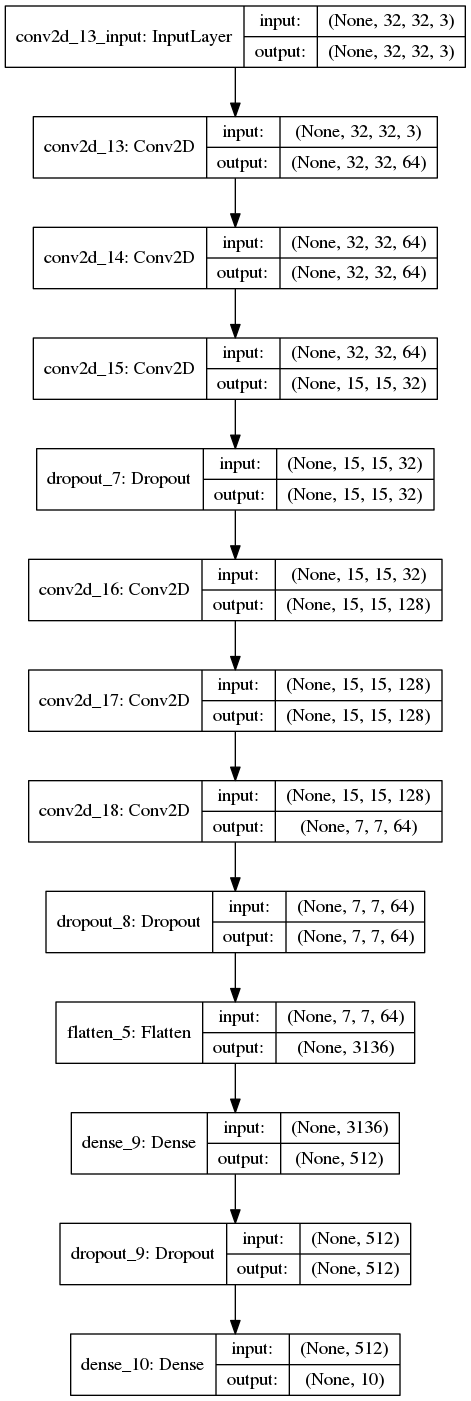

In [27]:
plot_model(model, to_file='aux.png', show_shapes=True)
Image(filename='aux.png')

chequear que cosa hace que dimsinuye la dim

In [28]:
opt = rmsprop(lr=0.001, decay=1e-3)
model.compile( optimizer=opt, loss='categorical_crossentropy' ,metrics=['acc'])
hist6 = model.fit(x_train, y_train,batch_size=100,epochs=25,
validation_data=(x_test, y_test),shuffle=True,verbose=1)

Train on 45741 samples, validate on 10000 samples
Epoch 1/25
45741/45741 [==============================] - 147s - loss: 1.7299 - acc: 0.3777 - val_loss: 1.5470 - val_acc: 0.4609
Epoch 2/25
45741/45741 [==============================] - 147s - loss: 1.2980 - acc: 0.5412 - val_loss: 1.2970 - val_acc: 0.5412
Epoch 3/25
45741/45741 [==============================] - 147s - loss: 1.1163 - acc: 0.6069 - val_loss: 1.0746 - val_acc: 0.6205
Epoch 4/25
45741/45741 [==============================] - 147s - loss: 0.9903 - acc: 0.6515 - val_loss: 1.0366 - val_acc: 0.6446
Epoch 5/25
45741/45741 [==============================] - 147s - loss: 0.8922 - acc: 0.6873 - val_loss: 0.9734 - val_acc: 0.6628
Epoch 6/25
45741/45741 [==============================] - 147s - loss: 0.8159 - acc: 0.7135 - val_loss: 0.9811 - val_acc: 0.6666
Epoch 7/25
45741/45741 [==============================] - 147s - loss: 0.7506 - acc: 0.7368 - val_loss: 0.9647 - val_acc: 0.6703
Epoch 8/25
45741/45741 [=======================

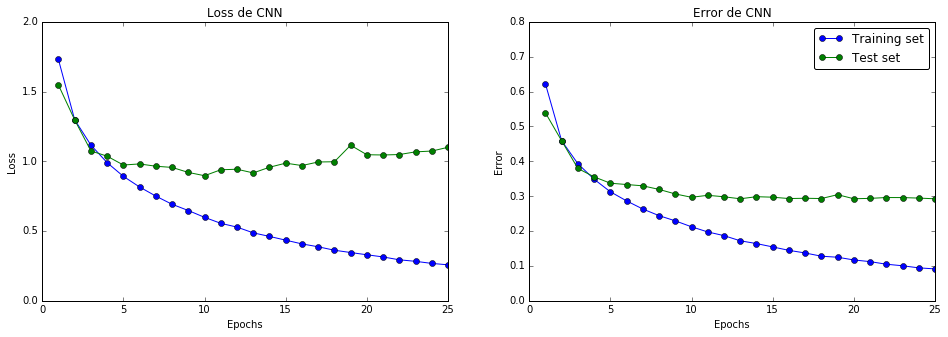

In [29]:
history_dict = hist6.history
plot_function(history_dict)

In [30]:
score = model.evaluate(x_test, y_test)
print "\nTEST CROSS ENTROPY LOSS = ", score[0]

print "\nTEST ACCURACY = ", score[1]

 9984/10000 [============================>.] - ETA: 0s
TEST CROSS ENTROPY LOSS =  1.10037714024

TEST ACCURACY =  0.7075


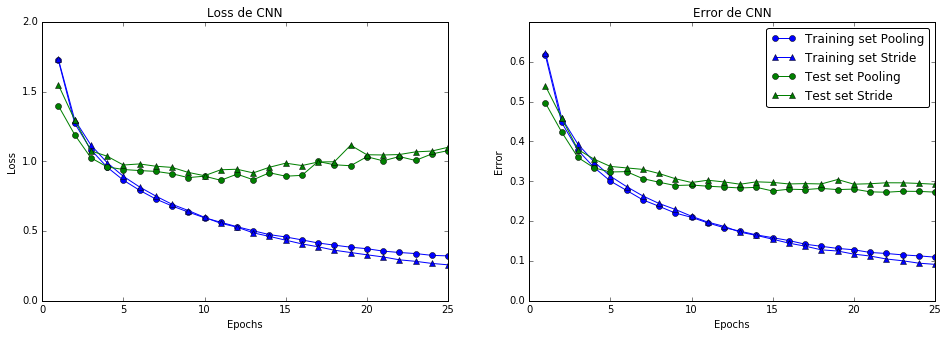

In [31]:
history_dict1 = hist4.history

history_dict2 = hist6.history

f, axarr = plt.subplots(1, 2,figsize=(16,5))

loss_values1 = history_dict1['loss']
val_loss_values1 = history_dict1['val_loss']
loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']
epochs1 = range(1, len(loss_values1) + 1)

axarr[0].plot(epochs1, loss_values1, 'bo-')
axarr[0].plot(epochs1, loss_values2, 'b^-')
axarr[0].plot(epochs1, val_loss_values1, 'go-')
axarr[0].plot(epochs1, val_loss_values2, 'g^-')
axarr[0].set_title('Loss de CNN')
axarr[0].set_ylim(0,2)
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Loss')

acc1 = history_dict1['acc']
val_acc1 = history_dict1['val_acc']
acc2 = history_dict2['acc']
val_acc2 = history_dict2['val_acc']

axarr[1].plot(epochs1, np.subtract(1,acc1), 'bo-', label = "Training set Pooling")
axarr[1].plot(epochs1, np.subtract(1,acc2), 'b^-', label = "Training set Stride")
axarr[1].plot(epochs1, np.subtract(1,val_acc1), 'go-', label = "Test set Pooling")
axarr[1].plot(epochs1, np.subtract(1,val_acc2), 'g^-', label = "Test set Stride")
axarr[1].set_title('Error de CNN')
axarr[1].set_ylim(0,0.7)
axarr[1].set_xlabel('Epochs')
axarr[1].set_ylabel('Error')
axarr[1].legend(loc="upper right", fancybox= True)
plt.show()

## G) Regularizar

In [32]:
from keras.preprocessing import image
datagen = image.ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(x_train)
hist7 = model.fit_generator(datagen.flow(x_train, y_train,batch_size=100),
        steps_per_epoch=x_train.shape[0]// 100,
        epochs=25,validation_data=(x_test, y_test),verbose=1)

Epoch 1/25
457/457 [==============================] - 147s - loss: 1.5716 - acc: 0.4473 - val_loss: 0.9932 - val_acc: 0.6539
Epoch 2/25
457/457 [==============================] - 147s - loss: 1.3702 - acc: 0.5124 - val_loss: 0.9813 - val_acc: 0.6616
Epoch 3/25
457/457 [==============================] - 147s - loss: 1.2995 - acc: 0.5389 - val_loss: 0.9293 - val_acc: 0.6749
Epoch 4/25
457/457 [==============================] - 147s - loss: 1.2453 - acc: 0.5554 - val_loss: 0.9318 - val_acc: 0.6722
Epoch 5/25
457/457 [==============================] - 147s - loss: 1.2173 - acc: 0.5660 - val_loss: 0.9287 - val_acc: 0.6774
Epoch 6/25
457/457 [==============================] - 147s - loss: 1.1901 - acc: 0.5756 - val_loss: 0.9300 - val_acc: 0.6777
Epoch 7/25
457/457 [==============================] - 147s - loss: 1.1671 - acc: 0.5898 - val_loss: 0.9094 - val_acc: 0.6826
Epoch 8/25
457/457 [==============================] - 147s - loss: 1.1469 - acc: 0.5911 - val_loss: 0.9028 - val_acc: 0.6831


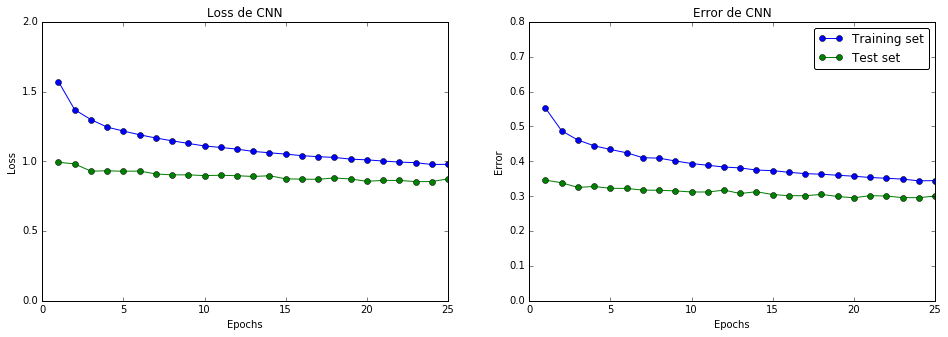

In [33]:
history_dict = hist7.history
plot_function(history_dict)

In [34]:
score = model.evaluate(x_test, y_test)
print "\nTEST CROSS ENTROPY LOSS = ", score[0]

print "\nTEST ACCURACY = ", score[1]

 9984/10000 [============================>.] - ETA: 0s
TEST CROSS ENTROPY LOSS =  0.874016395092

TEST ACCURACY =  0.6996


## H) Ejemplos confusos

en base al ultimo modelo ...

In [35]:
y_hat_class = model.predict_classes(x_test)
#print prob
#from keras.utils.np_utils import probas_to_classes

#y_hat_class = probas_to_classes(prob)
y_test_class = y_test.argmax(axis=1)

print "\nClases predecidas"
print y_hat_class
print "Clases reales"
print y_test_class

10000/10000 [==============================] - 6s     

Clases predecidas
[3 8 8 ..., 5 1 7]
Clases reales
[3 8 8 ..., 5 1 7]


In [36]:
y_hat_distintos= y_hat_class[np.not_equal(y_test_class,y_hat_class)]
y_test_distintos= y_test_class[np.not_equal(y_test_class,y_hat_class)]
aux = zip(y_hat_distintos,y_test_distintos)
print "Ejemplos mal clasificados ",len(aux)

frecuency = [ [i,aux.count(i)] for i in set(aux) ]
objetos_ordenados = np.asarray( sorted(frecuency,key=lambda x: x[1])[::-1] )
print "[(Predecido, Real), Frecuencia]"
print objetos_ordenados

Ejemplos mal clasificados  3004
[(Predecido, Real), Frecuencia]
[[(3, 5) 154]
 [(5, 3) 149]
 [(1, 9) 141]
 [(6, 4) 137]
 [(6, 3) 136]
 [(6, 2) 130]
 [(6, 5) 80]
 [(5, 7) 79]
 [(2, 3) 78]
 [(4, 2) 76]
 [(0, 2) 75]
 [(4, 7) 66]
 [(9, 1) 65]
 [(7, 4) 65]
 [(2, 4) 64]
 [(0, 8) 63]
 [(1, 8) 60]
 [(3, 2) 58]
 [(5, 2) 55]
 [(2, 0) 54]
 [(8, 0) 50]
 [(4, 3) 48]
 [(9, 0) 45]
 [(1, 0) 41]
 [(7, 5) 40]
 [(4, 5) 40]
 [(3, 4) 39]
 [(2, 5) 39]
 [(5, 4) 37]
 [(3, 6) 36]
 [(3, 7) 35]
 [(9, 3) 33]
 [(2, 6) 31]
 [(9, 8) 30]
 [(9, 7) 29]
 [(6, 7) 28]
 [(7, 2) 25]
 [(7, 3) 25]
 [(6, 0) 21]
 [(6, 9) 21]
 [(8, 1) 19]
 [(5, 6) 19]
 [(3, 8) 18]
 [(0, 3) 18]
 [(0, 9) 18]
 [(4, 6) 18]
 [(1, 3) 17]
 [(2, 7) 16]
 [(0, 4) 16]
 [(9, 5) 15]
 [(7, 9) 15]
 [(3, 9) 15]
 [(1, 4) 15]
 [(8, 9) 15]
 [(7, 0) 14]
 [(6, 1) 14]
 [(9, 2) 14]
 [(1, 5) 14]
 [(4, 0) 13]
 [(1, 7) 12]
 [(2, 8) 12]
 [(0, 7) 12]
 [(1, 2) 11]
 [(2, 9) 10]
 [(3, 0) 10]
 [(8, 3) 10]
 [(0, 5) 10]
 [(3, 1) 10]
 [(8, 4) 9]
 [(4, 8) 9]
 [(0, 1) 9]
 [(8, 5) 9

In [37]:
mayores = objetos_ordenados[:10]
print mayores
print label_names

[[(3, 5) 154]
 [(5, 3) 149]
 [(1, 9) 141]
 [(6, 4) 137]
 [(6, 3) 136]
 [(6, 2) 130]
 [(6, 5) 80]
 [(5, 7) 79]
 [(2, 3) 78]
 [(4, 2) 76]]
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [38]:
print "Los tipicos que se confunden son:"
for i in mayores:
    print "Se confunde un "+str(i[1])+" "+label_names[i[0][0]]+ " con "+label_names[i[0][1]]

Los tipicos que se confunden son:
Se confunde un 154 cat con dog
Se confunde un 149 dog con cat
Se confunde un 141 automobile con truck
Se confunde un 137 frog con deer
Se confunde un 136 frog con cat
Se confunde un 130 frog con bird
Se confunde un 80 frog con dog
Se confunde un 79 dog con horse
Se confunde un 78 bird con cat
Se confunde un 76 deer con bird


mas dificil de predecir y con el que se conufnden es el gato

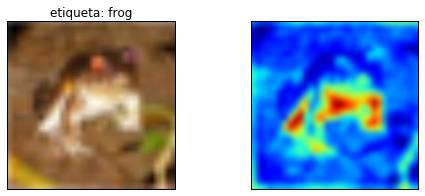

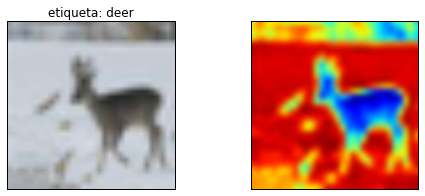

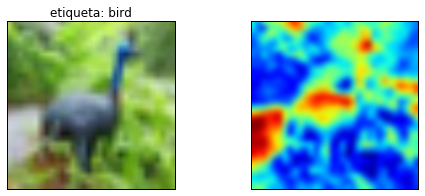

In [46]:
ver_imagen(X,Y,0)
ver_imagen(X,Y,20)
ver_imagen(X,Y,6)

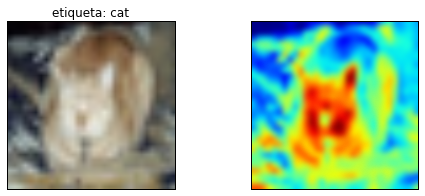

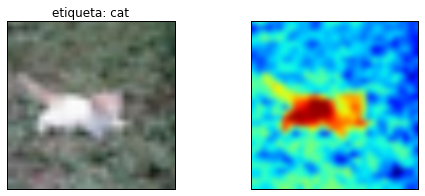

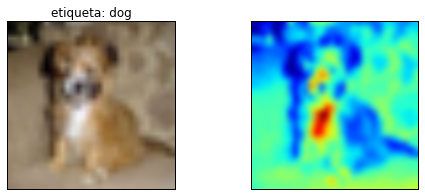

In [40]:
ver_imagen(X,Y,33)
ver_imagen(X,Y,39)
ver_imagen(X,Y,4600)

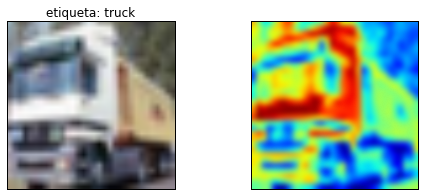

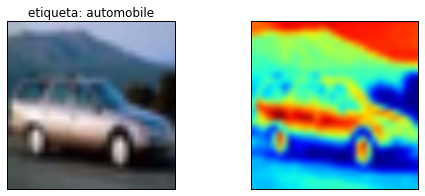

In [44]:
ver_imagen(X,Y,1)
ver_imagen(X,Y,4)